# Weighted K Nearest Neighbors

Algorithm: compute the K nearest neighbors of a trajectory as the predicted trajectories

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import multiprocessing as mp

In [2]:
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.visualization.visualize_sequences import viz_sequence

In [3]:
#root_dir = '/home/aaron/workspace/argoverse/data/forecasting_sample_v1.1/forecasting_sample/data'
root_dir = '/home/aaron/workspace/argoverse/data/forecasting_train_v1.1/train/data'
afl = ArgoverseForecastingLoader(root_dir)
avm = ArgoverseMap()
print('Total number of sequences:',len(afl))

Total number of sequences: 205942


In [4]:
def normalize_trajectory(traj):
    norm_traj = traj - traj[0]
    theta = -np.arctan2(norm_traj[-1][1],norm_traj[-1][0])
    rot_mat = ((np.cos(theta), -np.sin(theta)), (np.sin(theta), np.cos(theta)))
    norm_traj = np.matmul(rot_mat, norm_traj.T).T
    return norm_traj

In [5]:
def normalize_trajectory_caller(args):
    idx, agent_traj = args
    if idx % 1000 == 0:
        print(idx)
    norm_traj = normalize_trajectory(agent_traj)
    return idx, norm_traj

In [6]:
'''
num_workers = mp.cpu_count()//2
pool = mp.Pool(num_workers)
args = [(idx, traj.agent_traj) for idx, traj in enumerate(afl)]
res = pool.map(transform_trajectory, args)
lookup = sorted(res,key=lambda x:x[0])
np.save('lookup.npy', lookup)
'''

"\nnum_workers = mp.cpu_count()//2\npool = mp.Pool(num_workers)\nargs = [(idx, traj.agent_traj) for idx, traj in enumerate(afl)]\nres = pool.map(transform_trajectory, args)\nlookup = sorted(res,key=lambda x:x[0])\nnp.save('lookup.npy', lookup)\n"

In [7]:
def get_top_k(target_traj, lookup, k=6):
    norm_target_traj = normalize_trajectory(target_traj)
    distances = np.subtract(lookup[:,:20], norm_target_traj[:20])
    distances = np.linalg.norm(distances, axis=(1,2))
    top_k_idxs = np.argsort(distances)
    return distances, top_k_idxs[:k]

In [204]:
i = np.random.randint(len(avl))
#i = 0
val_traj = avl[i].agent_traj
distances, top_k_idxs = get_top_k(val_traj, lookup)

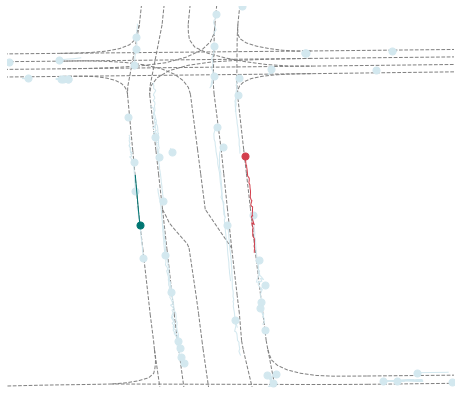

In [205]:
viz_sequence(avl[i].seq_df)

In [206]:
k = top_k_idxs[0]
predict_traj = lookup[k]
norm_val_traj = normalize_trajectory(val_traj)
for k in top_k_idxs:
    #plt.figure()
    predict_traj = lookup[k]
    #plt.plot(norm_val_traj[:,0], norm_val_traj[:,1],c='r')
    #plt.plot(predict_traj[:,0], predict_traj[:,1],c='b')

In [267]:
def get_multiple_forecasts(data, lookup, k=6, plot=False):
    predictions = list()
    agent_traj = data.agent_traj
    distances, top_k_idxs = get_top_k(agent_traj, lookup, k=6)
    if plot:
        plt.plot(agent_traj[0,0], agent_traj[0,1], '-o', c='r')
        plt.plot(agent_traj[:,0], agent_traj[:,1],c='r')
    for k in top_k_idxs:
        #plt.figure()
        #ax = plt.gca().set_aspect('equal')
        predict_traj = lookup[k]
        norm_agent_traj = agent_traj - agent_traj[0]
        theta = np.arccos(np.dot(predict_traj[19], norm_agent_traj[19])/ np.linalg.norm(predict_traj[19])/np.linalg.norm(norm_agent_traj[19]))
        if norm_agent_traj[19,1] < 0:
            theta *=-1
        rot_mat = ((np.cos(theta), -np.sin(theta)), (np.sin(theta), np.cos(theta)))
        t_predict_traj = predict_traj
        t_predict_traj = np.matmul(rot_mat, t_predict_traj.T).T
        t_predict_traj = t_predict_traj + agent_traj[0]
        t_predict_traj[:20] = agent_traj[:20]
        predictions.append(t_predict_traj)
        if plot:
            plt.plot(t_predict_traj[:20,0], t_predict_traj[:20,1],c='r')
            plt.plot(t_predict_traj[19:,0], t_predict_traj[19:,1],c=np.random.random(3,))
    return np.asarray(predictions)

In [242]:
root_dir = '/home/aaron/workspace/argoverse/data/forecasting_test_v1.1/test_obs/data'
#root_dir = '/home/aaron/workspace/argoverse/data/forecasting_sample_v1.1/forecasting_sample/data'
afl = ArgoverseForecastingLoader(root_dir)
lookup = np.load('lookup.npy', allow_pickle=True)

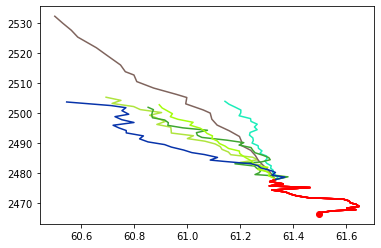

In [280]:
predictions = get_multiple_forecasts(afl[np.random.randint(len(afl))], lookup, plot=True)

In [256]:
output_all = dict()
counter = 1
for data in afl:
    print('\r'+str(counter)+'/'+str(len(afl)),end="")
    predictions = get_multiple_forecasts(data, lookup)
    seq_id = int(data.current_seq.name[:-4])
    output_all[seq_id] = predictions[:,20:,:]
    counter += 1
np.save('knn_baseline_output_all.npy', output_all)


1/78143(6, 30, 2)
2/78143(6, 30, 2)


In [221]:
from argoverse.evaluation.competition_util import generate_forecasting_h5

output_path = 'competition_files/'

generate_forecasting_h5(output_all, output_path, filename='knn_baseline') #this might take awhile

5/5